# Cross Entropy Loss

**WTF**. It's sounds scary. But this is a way to create a loss function for model based on categories. 

In [2]:
from fastai2.vision.all import *
from utils import *

## Create a Linear MNIST Model

First of all, let's create a Linear MNIST model we create in lesson 4. <br/>
We can build stuff on top of that.

In [3]:
im_path = untar_data(URLs.MNIST)

In [4]:
im_path.ls()

(#2) [Path('/storage/data/mnist_png/training'),Path('/storage/data/mnist_png/testing')]

In [5]:
(im_path/"training").ls()

(#10) [Path('/storage/data/mnist_png/training/9'),Path('/storage/data/mnist_png/training/6'),Path('/storage/data/mnist_png/training/7'),Path('/storage/data/mnist_png/training/0'),Path('/storage/data/mnist_png/training/4'),Path('/storage/data/mnist_png/training/5'),Path('/storage/data/mnist_png/training/3'),Path('/storage/data/mnist_png/training/2'),Path('/storage/data/mnist_png/training/1'),Path('/storage/data/mnist_png/training/8')]

In [6]:
(im_path/"training/9").ls()

(#5949) [Path('/storage/data/mnist_png/training/9/39927.png'),Path('/storage/data/mnist_png/training/9/52230.png'),Path('/storage/data/mnist_png/training/9/39692.png'),Path('/storage/data/mnist_png/training/9/33246.png'),Path('/storage/data/mnist_png/training/9/59344.png'),Path('/storage/data/mnist_png/training/9/14364.png'),Path('/storage/data/mnist_png/training/9/53342.png'),Path('/storage/data/mnist_png/training/9/53238.png'),Path('/storage/data/mnist_png/training/9/35444.png'),Path('/storage/data/mnist_png/training/9/34176.png')...]

In [7]:
def load_images(p):
    return torch.stack([tensor(Image.open(im)).float()/255 for im in p.ls()])

In [8]:
train_3s = load_images(im_path/"training/3")

In [9]:
IMAGE_SIZE = 28 * 28

In [10]:
def get_dataloader(pa, pb):
    im_as = load_images(pa)
    im_bs = load_images(pb)
    X = torch.cat([im_as, im_bs]).view(-1, IMAGE_SIZE)
    Y = tensor([1] * len(im_as) + [0] * len(im_bs)).view(-1, 1)
    
    return DataLoader(list(zip(X, Y)), batch_size=224)
    

In [11]:
train_dl = get_dataloader(im_path/"training/3", im_path/"training/7")

In [12]:
valid_dl = get_dataloader(im_path/"testing/3", im_path/"testing/7")

In [13]:
dls = DataLoaders(train_dl, valid_dl)

In [14]:
def mnist_loss(preds, Y):
    return (torch.sigmoid(preds) - Y).abs().float().mean()

In [15]:
def mnist_accuracy(preds, Y):
    to_lables = (torch.sigmoid(preds) > 0.5).float()
    return (to_lables == Y).float().mean()

In [16]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func=SGD, loss_func=mnist_loss, metrics=mnist_accuracy)

In [17]:
learn.fit(10, lr=1.)

epoch,train_loss,valid_loss,mnist_accuracy,time
0,0.620795,0.119067,0.927380,00:00
1,0.164949,0.260446,0.752699,00:00
2,0.063917,0.131768,0.885672,00:00
3,0.033326,0.088947,0.923454,00:00
4,0.023218,0.067867,0.942591,00:00
5,0.019471,0.055745,0.954858,00:00
6,0.017824,0.048204,0.962709,00:00
7,0.016921,0.043211,0.964671,00:00
8,0.016309,0.039665,0.966143,00:00
9,0.015841,0.036985,0.968597,00:00


## Current Model

Now we need to inspect how our model works. Specially, what are the prediction looks like.

In [18]:
X, Y = dls.one_batch()

In [19]:
preds, _ = learn.get_preds(dl=[(X, Y)])

In [20]:
preds.shape

torch.Size([224, 1])

As you can see, there's only one value in the prediction. 

If that's closer to 1, we will consider it as the first category. Otherwise it's in the second category.

## Multi Category Model

So, then how do we create a model for multiple categories. For that, our prediction should output columns for each of those categories.

This single column is knowns as an `activation`.

So, for a dataset with 3 categories, we need to model outputs 3 activations.

In [73]:
def get_dataloader_multi(pa, pb, pc):
    im_as = load_images(pa)
    im_bs = load_images(pb)
    im_cs = load_images(pc)
    X = torch.cat([im_as, im_bs, im_cs]).view(-1, IMAGE_SIZE)
    ## See. Now we identify each category by an index.
    Y = tensor([0] * len(im_as) + [1] * len(im_bs) + [2] * len(im_bs)).view(-1, 1)
    
    return DataLoader(list(zip(X, Y)), batch_size=224)

In [67]:
dl_train_multi = get_dataloader_multi(im_path/"training/1", im_path/"training/3", im_path/"training/5")

In [68]:
dl_valid_multi = get_dataloader_multi(im_path/"testing/1", im_path/"testing/3", im_path/"testing/5")

In [69]:
dls_multi = DataLoaders(dl_train_multi, dl_train_multi)

In [74]:
X, Y = dls_multi.one_batch()
X.shape, Y.shape

(torch.Size([224, 784]), torch.Size([224, 1]))

In [75]:
model_multi = nn.Linear(IMAGE_SIZE, 3)
learn_multi = Learner(dls_multi, model_multi, opt_func=SGD, loss_func=mnist_loss, metrics=mnist_accuracy)

In [76]:
learn_multi.fit(10, lr=1.)

epoch,train_loss,valid_loss,mnist_accuracy,time
0,0.625724,0.630046,0.335137,00:01
1,0.532421,0.510060,0.501549,00:00
2,0.511503,0.420584,0.621424,00:00
3,0.505808,0.377131,0.656317,00:00
4,0.503542,0.355136,0.670876,00:00
5,0.502210,0.342919,0.678018,00:00
6,0.501235,0.335468,0.681717,00:00
7,0.500453,0.330553,0.684250,00:00
8,0.499800,0.327104,0.686181,00:01
9,0.499243,0.324562,0.687930,00:03


## Inspecting Predictions

In [77]:
batchs = [(X, Y) for X,Y in dl_valid_multi]

### For 1

In [78]:
X, Y = batchs[0]

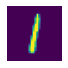

In [79]:
show_image(X[0].view(28, 28))

In [81]:
preds, _ = learn_multi.get_preds(dl=[(X, Y)])
preds[0:10]

tensor([[-5.7364, -5.7292, -5.7618],
        [-4.4396, -4.3240, -4.3491],
        [-3.5968, -3.6263, -3.5618],
        [-6.2857, -6.3388, -6.3670],
        [-4.2157, -4.2627, -4.1498],
        [-4.7434, -4.7533, -4.7693],
        [-4.6218, -4.5821, -4.5795],
        [-2.5519, -2.6448, -2.6019],
        [-4.4160, -4.3615, -4.3577],
        [-4.9493, -4.8949, -4.9307]])

### For 3

In [82]:
X, Y = batchs[int(len(batchs)/2)]

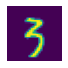

In [83]:
show_image(X[0].view(28, 28))

In [84]:
preds, _ = learn_multi.get_preds(dl=[(X, Y)])
preds[0:10]

tensor([[10.2571, 10.3083, 10.3254],
        [17.2409, 17.4715, 17.4188],
        [ 5.3463,  5.3424,  5.2992],
        [14.5205, 14.5418, 14.5055],
        [13.7440, 14.0344, 13.9420],
        [14.3314, 14.4772, 14.4610],
        [11.3035, 11.4784, 11.5185],
        [ 6.2877,  6.4514,  6.3502],
        [12.5024, 12.6683, 12.6422],
        [12.4961, 12.6083, 12.6317]])

### For 5

In [85]:
X, Y = batchs[-1]

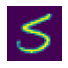

In [86]:
show_image(X[0].view(28, 28))

In [87]:
preds, _ = learn_multi.get_preds(dl=[(X, Y)])
preds[0:10]

tensor([[ 9.2959,  9.2812,  9.4774],
        [10.6278, 10.5437, 10.6662],
        [ 9.3409,  9.3723,  9.4077],
        [13.4009, 13.3765, 13.3672],
        [ 6.0300,  6.1146,  5.9489],
        [11.3884, 11.2243, 11.4415],
        [ 6.4599,  6.3190,  6.4792],
        [11.1509, 11.2363, 11.0460],
        [12.6472, 12.8648, 12.9999],
        [12.2484, 12.2540, 12.1645]])

As you can, see our model is now have 3 activations. It had worked for us even with our exisiting loss function.

But that's mostly due to the randomness and training. The current loss function is not suited for this.

## Softmax

We are trying to use softmax as a way to improve our loss function.

In [88]:
torch.softmax(tensor([1, 2, 30]).float(), dim=0)

tensor([2.5437e-13, 6.9144e-13, 1.0000e+00])

In [89]:
torch.softmax(tensor([1, 2, 30]).float(), dim=0).sum()

tensor(1.)

As you can see, softmax a function which converts all the numbers to get a sum of 1. This is useful for us. Because it can act as a set of probabilities.

Let's try to do apply this softmax for our prediction activations.

In [90]:
preds.shape

torch.Size([125, 3])

In [91]:
# We need use dim=1 to mention that, we need to do apply softmax for rows.
torch.softmax(preds, dim=1)[0:10]

tensor([[0.3140, 0.3095, 0.3765],
        [0.3380, 0.3107, 0.3512],
        [0.3225, 0.3328, 0.3448],
        [0.3398, 0.3316, 0.3286],
        [0.3322, 0.3615, 0.3063],
        [0.3444, 0.2923, 0.3632],
        [0.3462, 0.3008, 0.3530],
        [0.3345, 0.3643, 0.3012],
        [0.2728, 0.3391, 0.3881],
        [0.3419, 0.3438, 0.3144]])

In [92]:
torch.softmax(preds, dim=1).sum(dim=1)[0:10]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

## Softmax Loss Function

Let's re-create our loss function based on softmax.

In [133]:
def mnist_loss_softmax(preds, Y):
    preds = torch.softmax(preds, dim=1)
    # Why put minus.
    # Here we are using a probability. Larger the probability better.
    # But to make a loss we need minus it.
    length = len(preds)
    return -(preds[range(length), Y.view(length)]).mean()

mnist_loss_softmax(preds, Y)

tensor(-0.3356)

In [134]:
def mnist_accuracy_softmax(preds, Y):
    preds = torch.softmax(preds, dim=1)
    length = len(preds)
    probs = preds[range(length), Y.view(length)]
    
    return (probs > 0.5).float().mean()

mnist_accuracy_softmax(preds, Y)

tensor(0.)

In [151]:
## Let's re-run our model with that. and forget about the accucary a bit.
learn_multi = Learner(
    dls_multi,
    nn.Linear(IMAGE_SIZE, 3),
    opt_func=SGD,
    loss_func=mnist_loss_softmax,
    metrics=mnist_accuracy_softmax
)

In [152]:
learn_multi.fit(10, lr=1.)

epoch,train_loss,valid_loss,mnist_accuracy_softmax,time
0,-0.566194,-0.399019,0.363944,00:01
1,-0.797742,-0.543924,0.559582,00:01
2,-0.924973,-0.608963,0.615666,00:01
3,-0.954805,-0.660544,0.665027,00:01
4,-0.961763,-0.702412,0.707773,00:01
5,-0.964645,-0.733817,0.740243,00:01
6,-0.966318,-0.757670,0.765005,00:01
7,-0.967753,-0.775815,0.783208,00:01
8,-0.969041,-0.789752,0.797311,00:01
9,-0.969976,-0.801078,0.808079,00:01


Still, this is not **Cross Entropy Loss.**

But we will get to there.

### Using log function

With softmax we got a probability. But it does not track improvements nicely.
Because 0.9 vs 0.999 is quite bit improvement.

But the linear range does not show that. That's why we need to apply log. Let's do it.

In [144]:
def mnist_loss_softmax_log(preds, Y):
    preds = torch.softmax(preds, dim=1)
    # Why put minus.
    # Here we are using a probability. Larger the probability better.
    # But to make a loss we need minus it.
    length = len(preds)
    probs = preds[range(length), Y.view(length)]
    return -(torch.log(probs)).mean()

mnist_loss_softmax_log(preds, Y)

tensor(1.0950)

In [146]:
F.cross_entropy(preds, Y.view(-1))

tensor(1.0950)

**See. Both are the same.**

Let's train it again.

In [153]:
learn_multi = Learner(
    dls_multi,
    nn.Linear(IMAGE_SIZE, 3),
    opt_func=SGD,
    loss_func=mnist_loss_softmax_log,
    metrics=mnist_accuracy_softmax
)

In [154]:
learn_multi.fit(10, lr=1.)

epoch,train_loss,valid_loss,mnist_accuracy_softmax,time
0,0.505990,6.047721,0.300426,00:01
1,0.282377,7.202853,0.604187,00:01
2,0.448350,5.334094,0.656499,00:01
3,0.271790,2.170514,0.789330,00:01
4,0.149297,1.811164,0.812124,00:01
5,0.110740,1.612693,0.823713,00:01
6,0.092817,1.489796,0.830600,00:00
7,0.081893,1.403291,0.834263,00:01
8,0.074408,1.336439,0.836668,00:01
9,0.068877,1.283694,0.839237,00:01


**As you can see, it trains much better compared with `mnist_loss_softmax`.**